In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from functools import partial
from utils import chart_price, plot, v_backtester, c_backtester, perf, perf_var
import sys
sys.path.append('/home/tomek/ib_tools')
from indicators import get_ATR, get_signals
import matplotlib.pyplot as plt
from typing import NamedTuple
from collections import namedtuple
%matplotlib inline

In [2]:
from datastore_pytables import Store

In [3]:
store = Store()
store.keys()

['/cont/min/CL_20191120_NYMEX_USD',
 '/cont/min/ES_20191220_GLOBEX_USD',
 '/cont/min/GC_20191227_NYMEX_USD',
 '/cont/min/GE_20191216_GLOBEX_USD',
 '/cont/min/NKD_20191212_GLOBEX_USD',
 '/cont/min/NQ_20191220_GLOBEX_USD',
 '/cont/min/YM_20191220_ECBOT_USD',
 '/cont/min/ZB_20191219_ECBOT_USD',
 '/cont/min/ZF_20191231_ECBOT_USD',
 '/cont/min/ZN_20191219_ECBOT_USD']

In [4]:
multiplier = 20
#periods = 20
periods = [5, 10, 20, 40, 80, 160] 
ema_fast = 5
ema_slow = 120 # number of periods for moving average filter
#sl_atr = 1 # stop loss in ATRs
atr_periods = 180 # number of periods to calculate ATR on
time_int = 30 # interval in minutes to be used to define volume candle
commission = 2.1 # level of commision per transaction in dollars
bankroll = 15000

In [5]:
contract = store.read('/cont/min/GC_20191227_NYMEX_USD').sort_index()
#contract = pd.read_pickle('data/minute_GC_cont_non_active_included.pickle')
contract = contract.loc['20180101': '20181231']

In [6]:
#avg_vol = contract.loc['20190621':].volume.rolling(time_int).sum().mean()
avg_vol = contract.volume.rolling(time_int).sum().mean()
avg_vol

5394.121365802968

In [7]:
vol_candles = group_by_volume(contract, avg_vol)
"""
vol_candles = contract.resample('30min').agg({'open': 'first',
                                           'high': 'max',
                                           'low': 'min',
                                           'close': 'last',
                                           'volume': 'sum',
                                           'barCount': 'sum'}).reset_index().dropna()
"""
vol_candles['atr'] = get_ATR(vol_candles, atr_periods)
vol_candles

,date,open,high,low,close,barCount,volume,atr
label,,,,,,,,
0,2018-01-02 01:01:00,1305.3,1309.7,1304.6,1308.8,2081,5367,5.100000
1,2018-01-02 01:59:00,1308.8,1309.3,1307.3,1308.3,1908,4851,3.541389
2,2018-01-02 02:41:00,1308.4,1309.0,1306.2,1308.9,2862,6502,3.291508
3,2018-01-02 03:59:00,1308.9,1309.0,1307.4,1307.8,2137,5596,2.861557
4,2018-01-02 05:23:00,1307.8,1309.3,1307.3,1308.3,1949,5384,2.685396
...,...,...,...,...,...,...,...,...
11167,2018-12-31 17:57:00,1283.9,1284.7,1283.1,1284.2,2219,5430,2.188283
11168,2018-12-31 18:56:00,1284.2,1284.7,1282.6,1283.8,2210,5484,2.187308
11169,2018-12-31 19:28:00,1283.9,1284.3,1281.9,1282.1,1955,4777,2.189658


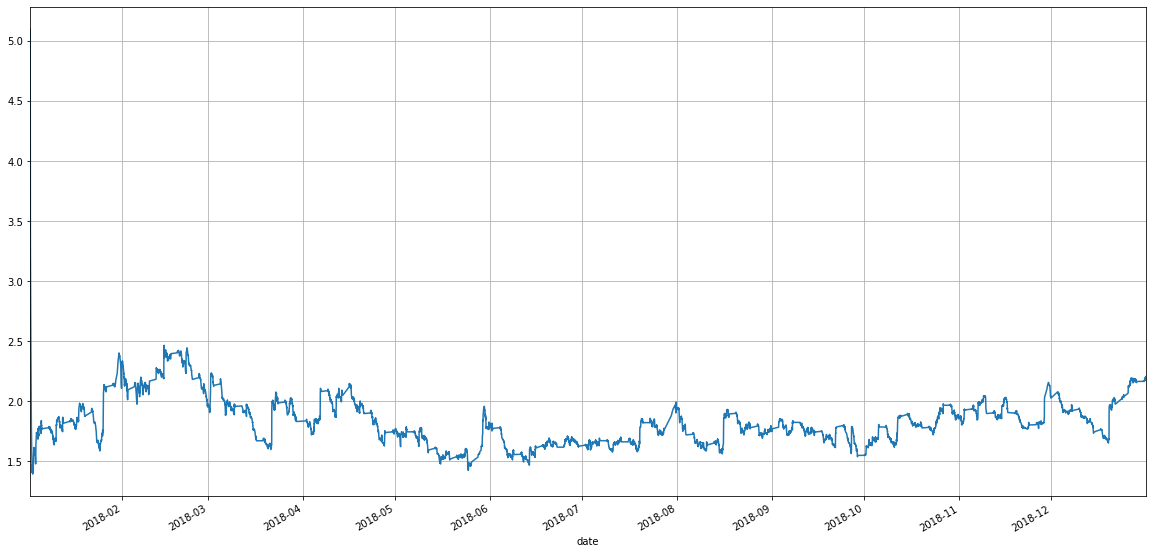

In [8]:
chart = vol_candles.set_index('date')
chart.atr.plot(figsize=(20,10), grid=True);

In [9]:
vol_candles.atr.mean(), vol_candles.atr.median()

(1.8185549373213472, 1.7864548393064061)

In [10]:
#vol_candles['atr'] = 20

In [11]:
data = vol_candles.copy()
data['ema_fast'] = data.close.ewm(span=ema_fast).mean()
data['ema_slow'] = data.close.ewm(span=ema_slow).mean()
#data['min'] = data.close.rolling(periods).min()
#data['max'] = data.close.rolling(periods).max()
rows_to_drop = max(*periods, ema_slow)
#rows_to_drop = max(periods, ema_fast)
data = data.iloc[rows_to_drop:]
data.reset_index(drop=True, inplace=True)

In [12]:
#data['buy_signal'] = (data.close >= data['max']) * 1
#data['sell_signal'] = (data.close <= data['min']) * -1
#data['signal'] = data.buy_signal + data.sell_signal
#del data['buy_signal']
#del data['sell_signal']
data['signal'] = get_signals(data.close, periods)
data['filter'] = np.sign(data['ema_fast'] - data['ema_slow'])
data['filtered_signal'] = data['signal'] * ((data['signal'] * data['filter']) == 1)
#data['filtered_signal'] = data['signal']

In [13]:
data.rename(columns={'open': 'price'}, inplace=True)

In [14]:
b = c_backtester(data, sl_atr=1, trailing_sl=True, active_close=True, block_stop=False, take_profit=0)
#results_c = perf(b, multiplier, bankroll) 

Annual return                  0.100887
Cumulative returns             0.103409
Annual volatility             0.0507467
Sharpe ratio                    1.91959
Calmar ratio                    5.06564
Stability                      0.921961
Max drawdown                 -0.0199159
Omega ratio                     1.42267
Sortino ratio                    3.7899
Skew                            1.37594
Kurtosis                        3.55044
Tail ratio                      1.88476
Daily value at risk         -0.00600693
Win percent                    0.431078
Average gain                    3.33372
Average loss                   -1.92335
Avg gain/loss ratio             1.73329
Position EV                    0.342857
Positions per day               1.54651
Days per position              0.646617
Actual avg. duration    0 days 04:51:00
Days                                258
Positions                           399
Trades                              798
Monthly EV                      11.1349


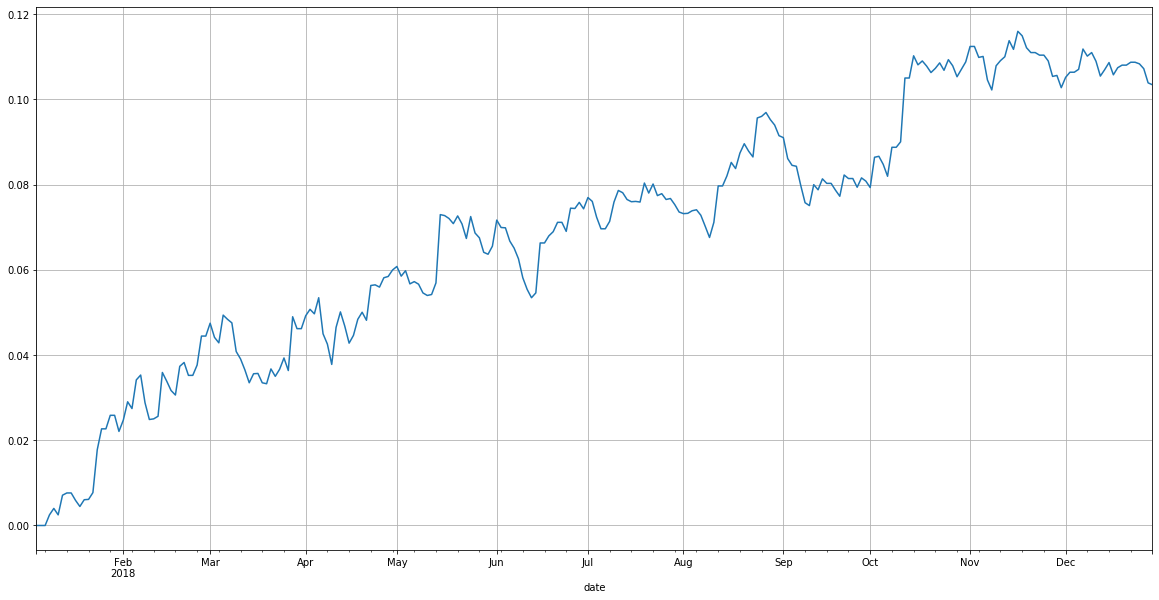

In [15]:
results = perf(b) 

In [16]:
prices = data.set_index('date').close.resample('B').last()
returns = prices.pct_change().fillna(0)
vols_returns = returns.ewm(span=5).std()
vols_prices = vols_returns * prices

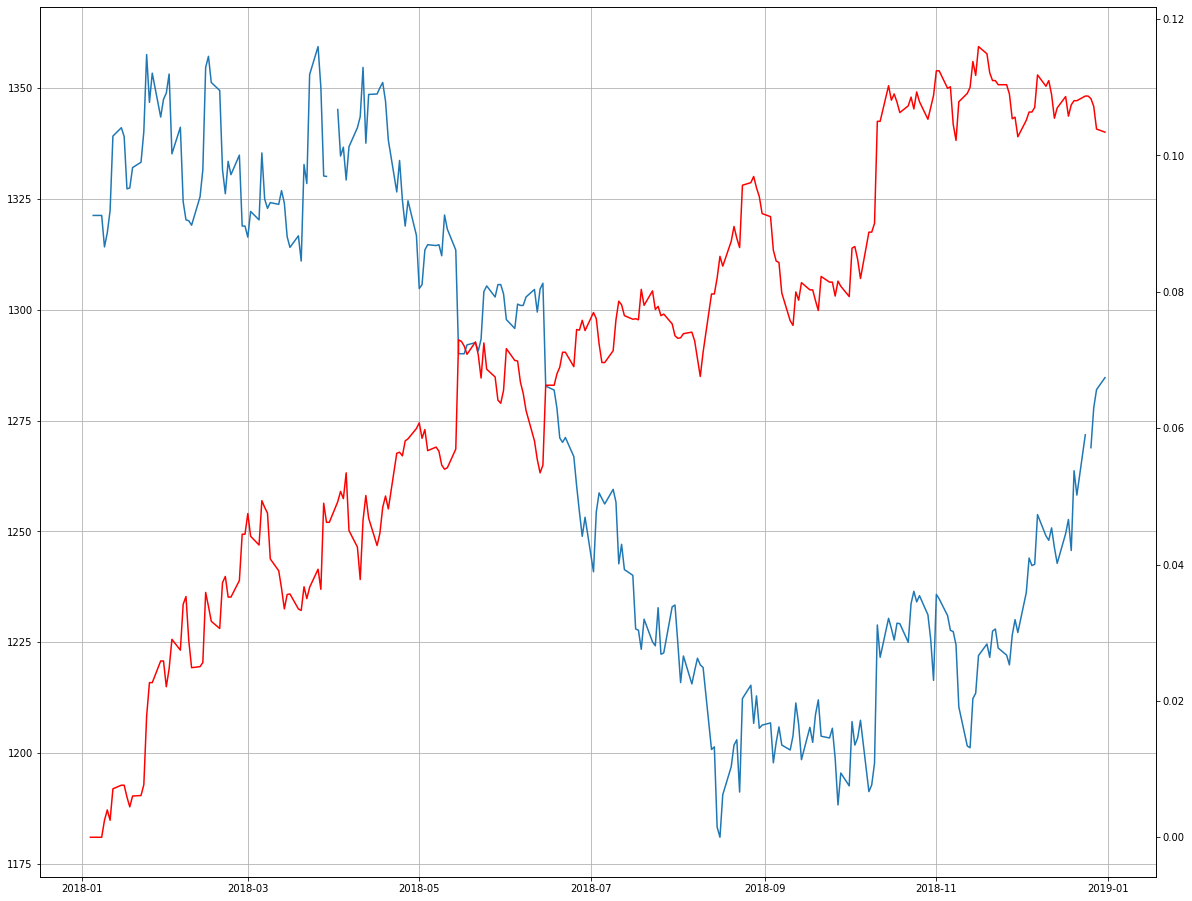

In [17]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 16))
ax = fig.add_subplot(111)
ax.plot(prices)
ax1 = ax.twinx()
ax1.plot(results.daily.path, color='red')
ax.grid()
plt.show();

In [18]:
monthly = pd.DataFrame({'open': results.daily.balance.resample('M').first(),
                        'close': results.daily.balance.resample('M').last()})
monthly['c'] = monthly['close'].shift().fillna(monthly['open'].iloc[0])
monthly['pnl'] = monthly['close'] - monthly['c']
del monthly['open']
monthly.columns = ['close', 'open', 'pnl']
monthly

,close,open,pnl
date,,,
2018-01-31,1352.1,1322.9,29.2
2018-02-28,1381.7,1352.1,29.6
2018-03-31,1384.0,1381.7,2.3
2018-04-30,1402.2,1384.0,18.2
2018-05-31,1409.6,1402.2,7.4
2018-06-30,1421.2,1409.6,11.6
2018-07-31,1420.2,1421.2,-1.0
2018-08-31,1443.9,1420.2,23.7
2018-09-30,1429.8,1443.9,-14.1


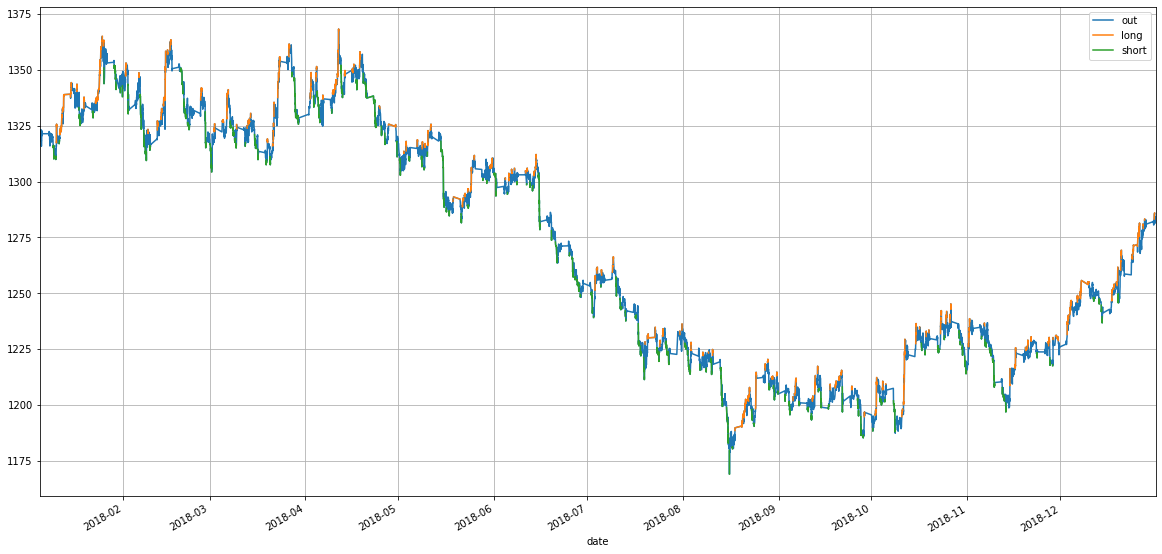

In [19]:
a = chart_price(b['price'], b['position'])

In [20]:
results.positions.sort_values('pnl')

,date_o,open,date_c,close,reason,pnl,duration
107,2018-04-06 14:31:00,-1324.8,2018-04-06 14:33:00,1332.1,stop-out,-7.3,00:02:00
59,2018-03-01 21:58:00,1321.3,2018-03-02 00:55:00,-1316.4,stop-out,-4.9,02:57:00
47,2018-02-16 10:46:00,1363.1,2018-02-16 13:25:00,-1359.0,stop-out,-4.1,02:39:00
58,2018-03-01 16:27:00,-1304.3,2018-03-01 16:39:00,1308.3,stop-out,-4.0,00:12:00
109,2018-04-09 12:55:00,-1330.6,2018-04-09 14:23:00,1334.6,stop-out,-4.0,01:28:00
...,...,...,...,...,...,...,...
17,2018-01-24 07:13:00,1341.4,2018-01-24 17:03:00,-1352.8,stop-out,11.4,09:50:00
187,2018-06-15 14:19:00,-1301.1,2018-06-15 16:16:00,1288.5,stop-out,12.6,01:57:00
266,2018-08-24 13:26:00,1198.3,2018-08-24 19:14:00,-1211.8,stop-out,13.5,05:48:00
95,2018-03-28 08:31:00,-1346.3,2018-03-29 02:35:00,1330.8,stop-out,15.5,18:04:00


In [21]:
#results.daily.to_pickle('GC_30_2019.pickle')

In [22]:
results.positions[results.positions['reason'] != 'stop-out']

,date_o,open,date_c,close,reason,pnl,duration
